In [1]:
!pip install tflite
!pip install --index-url https://google-coral.github.io/py-repo/ tflite_runtime

     |████████████████████████████████| 92kB 5.5MB/s 
Looking in indexes: https://google-coral.github.io/py-repo/
     |████████████████████████████████| 1.2MB 8.2MB/s 


# Import repository

In [2]:
!git clone https://github.com/carboni123/weeds-tflite

Cloning into 'weeds-tflite'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 1), reused 7 (delta 1), pack-reused 0
Unpacking objects: 100% (7/7), done.


#Import model

In [3]:
# !cp /content/drive/MyDrive/weeds.tflite ./model.tflite
!cp /content/weeds-tflite/weeds.tflite ./model.tflite

In [4]:
import numpy as np
import tflite_runtime.interpreter as tflite

# Load the TFLite model and allocate tensors.
interpreter = tflite.Interpreter(model_path="/content/model.tflite")
interpreter.allocate_tensors()
model= interpreter

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.uint8)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
# print(output_data)

#Load image


In [5]:
import cv2
import time
from PIL import Image


def resize_img_preprocess(image_path, input_size):
  image = cv2.imread(image_path)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  imH, imW, _ = image.shape 
  image_resized = cv2.resize(image_rgb, input_size)
  input_data = np.expand_dims(image_resized, axis=0)
  return image_resized


def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  # img = tfio.read_file(image_path)
  # img = tfio.decode_image(img, channels=3)
  # img = tf.image.convert_image_dtype(img, tf.uint8)
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  original_image = img
  # resized_img = tf.image.resize(img, input_size)
  # resized_img = resized_img[tf.newaxis, :]
  resized_img= resize_img_preprocess(image_path, input_size)
  return resized_img, original_image


def set_input_tensor(interpreter, image):
  """Set the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Retur the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  # Feed the input image to the model
  set_input_tensor(interpreter, image)
  # interpreter.invoke()

  start_time = time.monotonic()
  interpreter.invoke()
  elapsed_ms = (time.monotonic() - start_time) * 1000
  print(f'Inference Time: {np.round_(elapsed_ms,2)} ms')
  
  # Get all outputs from the model
  boxes = get_output_tensor(interpreter, 0)
  classes = get_output_tensor(interpreter, 1)
  scores = get_output_tensor(interpreter, 2)
  count = int(get_output_tensor(interpreter, 3))

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image

    # color = [int(c) for c in COLORS[class_id]]
    color= (255, 0, 0) #Blue
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8
  

Inference Time: 2311.39 ms


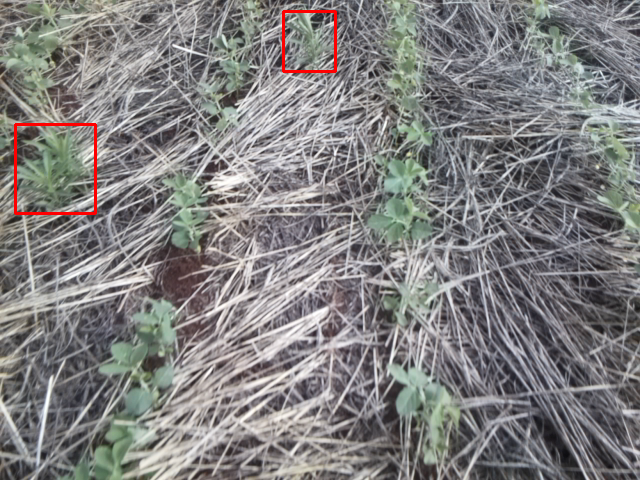

In [9]:
model_path= '/content/model.tflite'
DETECTION_THRESHOLD = 0.3
IMG_PATH= '/content/weeds-tflite/img_1597293167.46.png' #sample image

# Load the TFLite model
interpreter = tflite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    IMG_PATH,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
imsave= Image.fromarray(detection_result_image)
Image.fromarray(detection_result_image)


In [10]:
imsave.save('test.png') #Save detection in file

#Time inference

In [11]:
# def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
image_path= IMG_PATH
interpreter= interpreter
threshold= 0.3

# Load the input shape required by the model
_, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

# Load the input image and preprocess it
# def preprocess_image(image_path, input_size):

  # """Preprocess the input image to feed to the TFLite model"""

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
original_image = img

def resize_img_preprocess(image_path, input_size):
  image = cv2.imread(image_path)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  imH, imW, _ = image.shape 
  image_resized = cv2.resize(image_rgb, input_size)
  input_data = np.expand_dims(image_resized, axis=0)
  return image_resized
  
resized_img= resize_img_preprocess(image_path, (input_height, input_width))

# resized_img = tf.image.resize(img, (input_height, input_width))
# resized_img = resized_img[tf.newaxis, :]
# return resized_img, original_image

# preprocessed_image, original_image = preprocess_image(image_path,(input_height, input_width))

preprocessed_image= resized_img
original_image= img

set_input_tensor(interpreter, preprocessed_image)

In [12]:
%%time
interpreter.invoke()


CPU times: user 2.33 s, sys: 959 µs, total: 2.33 s
Wall time: 2.33 s


In [13]:
# Get all outputs from the model
boxes = get_output_tensor(interpreter, 0)
classes = get_output_tensor(interpreter, 1)
scores = get_output_tensor(interpreter, 2)
count = int(get_output_tensor(interpreter, 3))

results = []
for i in range(count):
  if scores[i] >= threshold:
    result = {
      'bounding_box': boxes[i],
      'class_id': classes[i],
      'score': scores[i]
    }
    results.append(result)
results= results

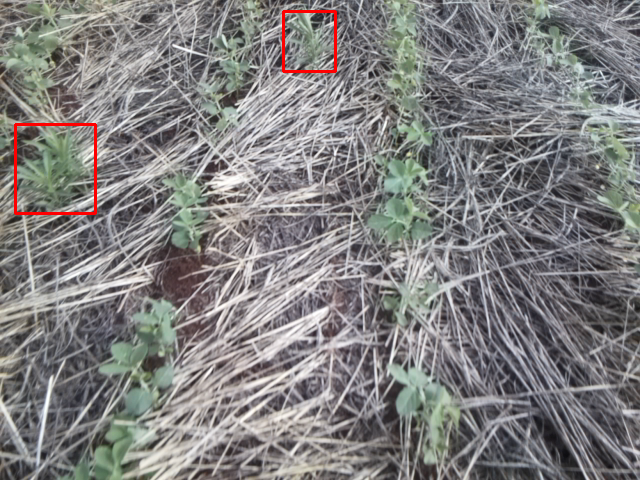

In [14]:

# Plot the detection results on the input image
original_image_np = original_image.astype(np.uint8)
for obj in results:
  # Convert the object bounding box from relative coordinates to absolute
  # coordinates based on the original image resolution
  ymin, xmin, ymax, xmax = obj['bounding_box']
  xmin = int(xmin * original_image_np.shape[1])
  xmax = int(xmax * original_image_np.shape[1])
  ymin = int(ymin * original_image_np.shape[0])
  ymax = int(ymax * original_image_np.shape[0])

  # Find the class index of the current object
  class_id = int(obj['class_id'])

  # Draw the bounding box and label on the image
  cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), (255,0,0), 2)

# Return the final image
original_uint8 = original_image_np.astype(np.uint8)

Image.fromarray(original_uint8)